In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [6]:
train = pd.read_csv('data/train.csv', dtype = {'challenge_sequence': 'i'})
test = pd.read_csv('data/test.csv', dtype = {'challenge_sequence': 'i'})
challenge_data = pd.read_csv('data/challenge_data.csv', 
                dtype = { 'category_id': 'O' })

### Fill NaN

In [7]:
cat_columns = ['challenge_ID', 'programming_language', 'challenge_series_ID', 'author_ID', 'author_gender',
               'author_org_ID', 'category_id']

In [8]:
for col in cat_columns:
    challenge_data[col].fillna('-999', inplace=True)
challenge_data['total_submissions'].fillna(challenge_data.total_submissions.median(), inplace=True)

### Get publish_date features

In [9]:
from datetime import datetime
challenge_data['publish_day'] = challenge_data.publish_date.apply(lambda x: x[:2])
challenge_data['publish_month'] = challenge_data.publish_date.apply(lambda x: x[3:5])
challenge_data['publish_year'] = challenge_data.publish_date.apply(lambda x: x[6:])
challenge_data['publish_weekday'] = challenge_data.publish_date.apply(lambda x: datetime.strptime(x, '%d-%m-%Y').weekday())
challenge_data = challenge_data.drop('publish_date', axis=1)

### Clip total_submissions

In [10]:
q99 = challenge_data.total_submissions.quantile(0.99)
challenge_data['total_submissions'] = challenge_data.total_submissions.apply(lambda x: np.clip(x, 0, q99))

In [11]:
challenge_data.head()

,challenge_ID,programming_language,challenge_series_ID,total_submissions,author_ID,author_gender,author_org_ID,category_id,publish_day,publish_month,publish_year,publish_weekday
0,CI23478,2,SI2445,37.0,AI563576,M,AOI100001,-999,06,05,2006,5
1,CI23479,2,SI2435,48.0,AI563577,M,AOI100002,32,17,10,2002,3
2,CI23480,1,SI2435,15.0,AI563578,M,AOI100003,-999,16,10,2002,2
3,CI23481,1,SI2710,236.0,AI563579,M,AOI100004,70,19,09,2003,4
4,CI23482,2,SI2440,137.0,AI563580,M,AOI100005,-999,21,03,2002,3


### Numericalize

In [12]:
from sklearn.preprocessing import LabelEncoder
label_encoders = {col: LabelEncoder().fit(challenge_data[col]) for col in cat_columns}

In [13]:
train['challenge_id'] = label_encoders['challenge_ID'].transform(train.challenge)

### Train - Dev split

In [14]:
train.user_id.nunique()

69532

In [15]:
train_size = 60000
np.random.seed(42)
user_ids = train.user_id.copy(deep=True).unique()
np.random.shuffle(user_ids)
train_ids, dev_ids = set(user_ids[:train_size]), set(user_ids[train_size:])

In [16]:
train_data = train[train.user_id.apply(lambda x: x in train_ids)]
dev_data = train[train.user_id.apply(lambda x: x in dev_ids)]

### Get batches

In [17]:
train.groupby('user_id').challenge_sequence.nunique().value_counts()

13    69532
Name: challenge_sequence, dtype: int64

In [18]:
def get_sequences(ids, df):
    sequences = []
    targets = []
    for user_id in ids:
        rows = df[df.user_id == user_id].sort_values('challenge_sequence')
        challenges = list(rows['challenge_id'])
        for i in range(10, 13):
            sequences.append(challenges[:i])
            targets.append(challenges[i])
    return sequences, targets

In [19]:
train_sequences, train_targets = get_sequences(train_ids, train_data)
dev_sequences, dev_targets = get_sequences(dev_ids, dev_data)

In [20]:
len(train_sequences), len(train_targets), len(dev_sequences), len(dev_targets)

(180000, 180000, 28596, 28596)

In [21]:
sequence_lengths = list(set([len(seq) for seq in train_sequences + dev_sequences]))

In [212]:
import pickle
with open('_data/data.pkl', 'wb') as f:
    pickle.dump({
        'train_sequences': train_sequences,
        'train_targets': train_targets,
        'train_sequences': train_sequences,
        'dev_sequences': dev_sequences
    }, f)

In [38]:
import torch
from torch.autograd import Variable

def get_random_batch(sequences, targets, batch_size, sequence_lengths, embedding_columns, numeric_columns):
    length = np.random.choice(sequence_lengths)
    candidates = np.array([(seq, target) for seq, target in zip(sequences, targets) if len(seq)==length])
    batch = candidates[np.random.choice(len(candidates), batch_size)]
    sequences_batch, targets_batch = zip(*batch)
    embedding_batch = [[challenge.loc[seq][col].astype('int').values for seq in sequences_batch] for col in embedding_columns]
    numeric_batch = [challenge.loc[seq][numeric_columns].astype('int').values for seq in sequences_batch]
    return sequences_batch, \
           Variable(torch.LongTensor(np.array(embedding_batch))).transpose(1, 2).cuda(), \
           Variable(torch.FloatTensor(np.array(numeric_batch))).transpose(0, 1).cuda(), \
           Variable(torch.LongTensor(targets_batch)).cuda()

### Encode columns

In [29]:
one_hot_columns = ['programming_language', 'author_gender']
embedding_columns = ['challenge_series_ID', 'author_ID', 'author_org_ID', 'category_id']
plain_columns = ['total_submissions', 'publish_day', 'publish_month', 'publish_year', 'publish_weekday']

In [30]:
challenge = challenge_data.copy(deep=True)
for col in label_encoders:
    challenge[col] = label_encoders[col].transform(challenge[col])
challenge = challenge.set_index('challenge_ID')
challenge = pd.get_dummies(challenge, columns=one_hot_columns)
numeric_columns = [col for col in challenge.columns if col not in embedding_columns]

In [31]:
from sklearn.preprocessing import MinMaxScaler
scalers = {col: MinMaxScaler() for col in plain_columns}
for col in plain_columns:
    challenge[col] = scalers[col].fit_transform(challenge[col].astype(float).values.reshape(-1, 1))

In [41]:
sequences_batch, embedding_batch, numeric_batch, target_batch = get_random_batch(
        train_sequences, train_targets, 128, sequence_lengths, embedding_columns, numeric_columns)
# sequences_batch: (BS, SL)
# embedding_batch: (n_embedding_columns, SL, BS)
# numeric_batch: (SL, BS, n_numeric_columns)
# target_batch: (BS)

In [42]:
embedding_batch.shape, numeric_batch.shape, target_batch.shape

(torch.Size([4, 11, 128]), torch.Size([11, 128, 11]), torch.Size([128]))

In [111]:
np.set_printoptions(precision=4, suppress=True)

## Model

In [43]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

In [56]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_sizes, embedding_sizes, features_size, hidden_size,
                    output_size, batch_size, n_layers, dropout_p, USE_CUDA=False):
        super(LSTMClassifier, self).__init__()
        self.input_sizes = input_sizes
        self.embedding_sizes = embedding_sizes
        self.features_size = features_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.USE_CUDA = USE_CUDA
        
        self.emb1 = nn.Embedding(input_sizes[0], embedding_sizes[0]).cuda()
#         self.emb2 = nn.Embedding(input_sizes[1], embedding_sizes[1]).cuda()
#         self.emb3 = nn.Embedding(input_sizes[2], embedding_sizes[2]).cuda()
        self.emb4 = nn.Embedding(input_sizes[3], embedding_sizes[3]).cuda()
        
#         embeddings = [nn.Embedding(input_size, embedding_size).cuda() \
#                               for input_size, embedding_size in zip(input_sizes, embedding_sizes)]
#         self.emb1, self.emb2, self.emb3, self.emb4 = embeddings
        
#         n_inputs = sum(embedding_sizes) + features_size
        n_inputs = embedding_sizes[0] + embedding_sizes[3] + features_size # without author ID / org ID
    
        self.lstm = nn.LSTM(n_inputs, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
        self.hidden = self.init_hidden(batch_size)
        
    def forward(self, embedding_batch, numeric_batch, last_hidden):
        '''
        embedding_batch: (n_embedding_columns, SL, BS)
        numeric_batch: (SL, BS, n_numeric_columns)
        last_hidden: ( (n_layers, BS, HS), (n_layers, BS, HS) )
        target_batch: (BS)
        output: (BS, output_size)
        '''
        embedded_input = torch.cat((self.emb1(embedding_batch[0]),
#                                     self.emb2(embedding_batch[1]),
#                                     self.emb3(embedding_batch[2]),
                                    self.emb4(embedding_batch[3])), 2)
        
#         embeddings = [self.emb1, self.emb2, self.emb3, self.emb4]
#         embedded_input = torch.cat([embeddings[idx](embedding_batch[idx]) \
#                                     for idx in range(len(input_sizes))], 2)
        # embedded_input: (SL, BS, sum(embedding_sizes))
        rnn_input = torch.cat((embedded_input, numeric_batch), 2)
        # rnn_input: (SL, BS, sum(embedding_sizes) + features_size)
        rnn_output, hidden = self.lstm(rnn_input, last_hidden)
        # rnn_output: (SL, BS, HS)
        rnn_output = rnn_output.squeeze(0)
        # rnn_output: (BS, HS)
        output = F.log_softmax(self.out(rnn_output), 1)
        # output: (BS, OS)        
        return output, hidden    
    
    def init_hidden(self, batch_size):
        hidden = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))
        cell = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))
        if self.USE_CUDA:
            hidden = hidden.cuda()
            cell = cell.cuda()
        return (hidden, cell)

In [57]:
input_sizes = [len(label_encoders[col].classes_) for col in embedding_columns]
embedding_sizes = [10, 15, 15, 8]
features_size = len(numeric_columns)
hidden_size = 512
output_size = len(label_encoders['challenge_ID'].classes_)
batch_size = 256
n_layers = 2
dropout_p = 0.5
USE_CUDA = True

In [58]:
_, embedding_batch, numeric_batch, target_batch = get_random_batch(
        train_sequences, train_targets, batch_size, sequence_lengths, embedding_columns, numeric_columns)

In [46]:
model = LSTMClassifier(input_sizes, embedding_sizes, features_size, 
                hidden_size, output_size, batch_size, n_layers, dropout_p, USE_CUDA)
model = model.cuda()

In [313]:
# embedding_batch: (n_embedding_columns, SL, BS)
# numeric_batch: (SL, BS, n_numeric_columns)
hidden = model.init_hidden(batch_size)
output, hidden = model(embedding_batch, numeric_batch, hidden)
# output: (SL, BS, OS)

In [297]:
output.shape, hidden[0].shape, hidden[1].shape

(torch.Size([11, 128, 5606]),
 torch.Size([2, 128, 512]),
 torch.Size([2, 128, 512]))

In [300]:
target_batch.min()

Variable containing:
 185
[torch.cuda.LongTensor of size 1 (GPU 0)]

In [53]:
def train_step(embedding_batch, numeric_batch, target_batch, model, 
        optimizer, criterion, USE_CUDA=False, train=True, clip=5.0):
    if train:
        optimizer.zero_grad()
    loss = 0
    batch_size = numeric_batch.shape[1]
    hidden = model.init_hidden(batch_size)
    output, hidden = model(embedding_batch, numeric_batch, hidden)
    loss = criterion(output[-1], target_batch)
    if train:
        loss.backward()
        torch.nn.utils.clip_grad_norm(filter(lambda p: p.requires_grad, 
                                             model.parameters()), clip)
        optimizer.step()
    return loss.data[0]
    
def evaluate(embedding_batch, numeric_batch, USE_CUDA=False):
    batch_size = numeric_batch.shape[1]
    hidden = model.init_hidden(batch_size)
    output, hidden = model(embedding_bath, numeric_batch, hidden)
    return output   

### Training

In [67]:
input_sizes = [len(label_encoders[col].classes_) for col in embedding_columns]
embedding_sizes = [20, 15, 15, 20]
features_size = len(numeric_columns)
hidden_size = 512
output_size = len(label_encoders['challenge_ID'].classes_)
batch_size = 256
n_layers = 2
dropout_p = 0.5
USE_CUDA = True

In [66]:
input_sizes

[436, 3485, 1718, 195]

In [68]:
model = LSTMClassifier(input_sizes, embedding_sizes, features_size, 
                hidden_size, output_size, batch_size, n_layers, dropout_p, USE_CUDA)
model = model.cuda()

In [61]:
# all_parameters = [model.embeddings[i].parameters() \
#                         for i in range(len(embedding_columns))] + \
#                         list(model.parameters())

In [69]:
learning_rate = 3e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

In [70]:
import time
n_epochs = 10000
plot_every = 10
print_every = 20
validate_every = 100
train_losses = []
validation_losses = []
print_loss_total = 0
plot_loss_total = 0

In [71]:
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

def as_minutes(s):
    return f'{int(s//60)}m {int(s%60)}s'

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / percent
    rs = es - s
    return f'{as_minutes(s)} (- {as_minutes(rs)})'

def plot_losses(train_loss, val_loss, scale):
    plt.figure(figsize=(10,5))
    plt.plot(train_loss)
    plt.plot([(x + 1) * scale - 1 for x in range(len(val_loss))], val_loss)
    plt.legend(['train loss', 'validation loss'])

In [ ]:
start = time.time()
for epoch in range(1, n_epochs + 1):
    _, embedding_batch, numeric_batch, target_batch = get_random_batch(
        train_sequences, train_targets, batch_size, sequence_lengths, embedding_columns, numeric_columns)
    loss = train_step(embedding_batch, numeric_batch, target_batch, model, 
        optimizer, criterion, USE_CUDA=True, train=True, clip=5.0)
    print_loss_total += loss
    plot_loss_total += loss
    
    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print(f'{time_since(start, epoch / n_epochs)} ({epoch} {epoch / n_epochs * 100:.2f}%) train_loss: {print_loss_avg:.4f}', end=' ')
        
    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        train_losses.append(plot_loss_avg)
        plot_loss_total = 0
    
    if epoch % validate_every == 0:
        _, embedding_batch, numeric_batch, target_batch = get_random_batch(
            dev_sequences, dev_targets, batch_size, sequence_lengths, embedding_columns, numeric_columns)
        eval_loss = train_step(embedding_batch, numeric_batch, target_batch, model, 
            optimizer, criterion, USE_CUDA=True, train=False, clip=5.0)
        validation_losses.append(eval_loss)
        print(f'- val_loss: {eval_loss:.4f}', end='')
    
    if epoch % print_every == 0:
        print()

0m 18s (- 149m 47s) (20 0.20%) train_loss: 5.5209 
0m 35s (- 147m 42s) (40 0.40%) train_loss: 5.2434 
0m 53s (- 147m 4s) (60 0.60%) train_loss: 4.9481 
1m 10s (- 146m 25s) (80 0.80%) train_loss: 4.7801 
1m 28s (- 146m 0s) (100 1.00%) train_loss: 4.7050 - val_loss: 4.6391
1m 47s (- 146m 50s) (120 1.20%) train_loss: 4.6229 
2m 4s (- 146m 12s) (140 1.40%) train_loss: 4.5300 
2m 22s (- 145m 37s) (160 1.60%) train_loss: 4.4933 
2m 39s (- 145m 10s) (180 1.80%) train_loss: 4.3873 
2m 57s (- 144m 51s) (200 2.00%) train_loss: 4.3238 - val_loss: 4.2387
3m 15s (- 145m 5s) (220 2.20%) train_loss: 4.2628 
3m 33s (- 144m 39s) (240 2.40%) train_loss: 4.2179 
3m 51s (- 144m 18s) (260 2.60%) train_loss: 4.2161 
4m 8s (- 143m 58s) (280 2.80%) train_loss: 4.1846 
4m 26s (- 143m 39s) (300 3.00%) train_loss: 4.1592 - val_loss: 4.3332
4m 44s (- 143m 41s) (320 3.20%) train_loss: 4.1108 
5m 2s (- 143m 19s) (340 3.40%) train_loss: 4.0899 
5m 20s (- 142m 57s) (360 3.60%) train_loss: 4.0532 
5m 37s (- 142m 34s) 

In [75]:
torch.save(model, 'data/model_256bs_10000e')

/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type LSTMClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [76]:
torch.save(model.state_dict(), 'data/model_256bs_10000e_weights')

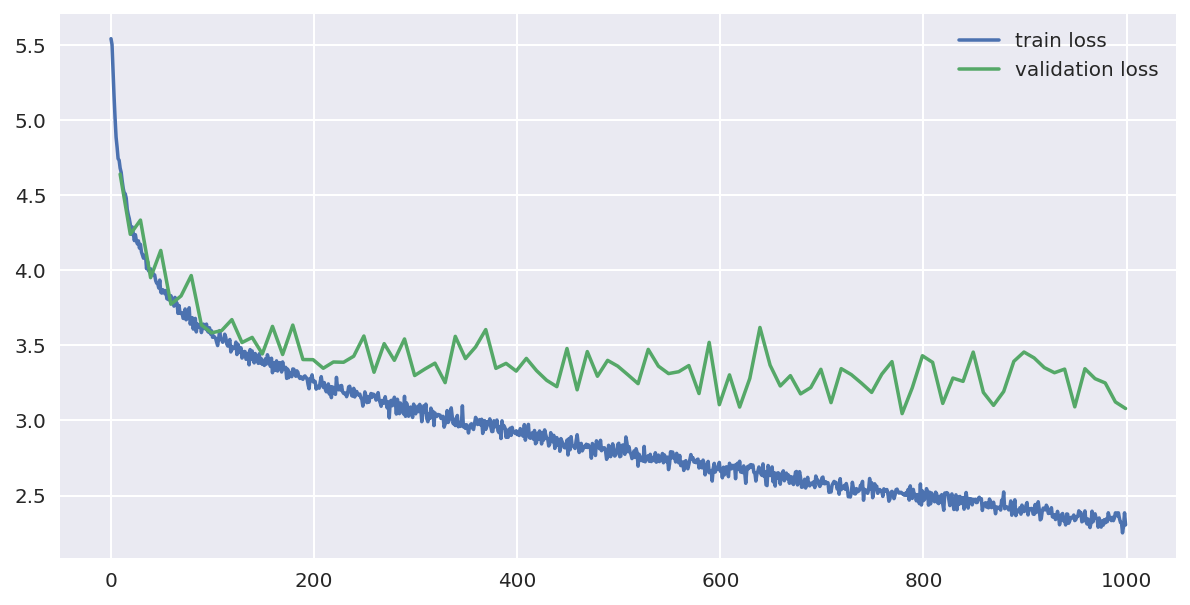

In [74]:
plot_losses(train_losses, validation_losses, validate_every // plot_every)

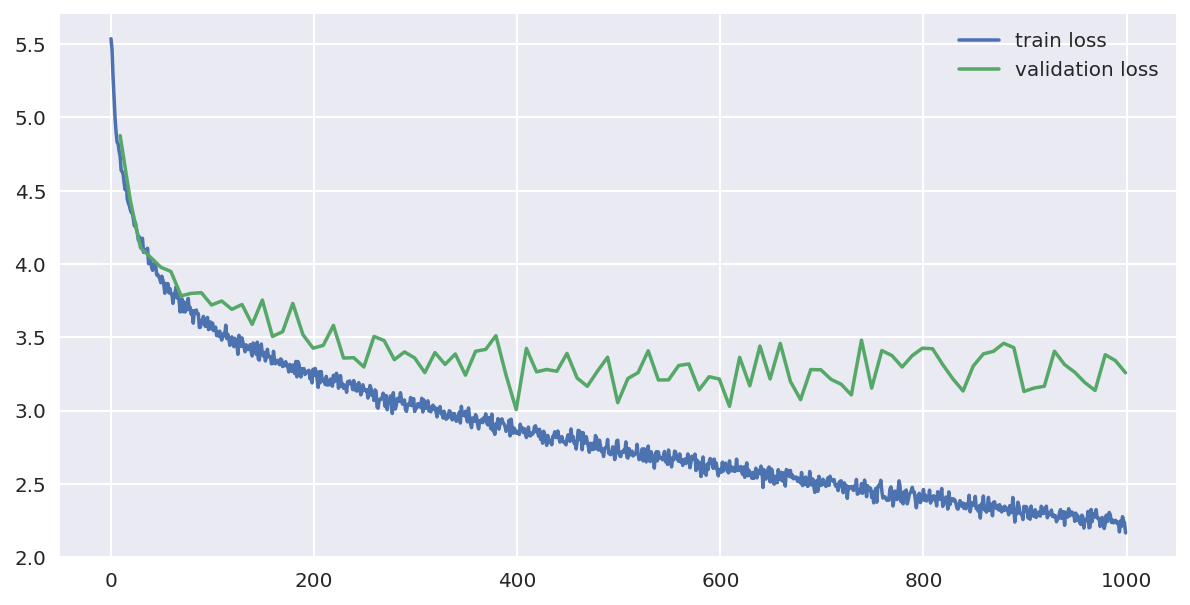

In [55]:
plot_losses(train_losses, validation_losses, validate_every // plot_every)

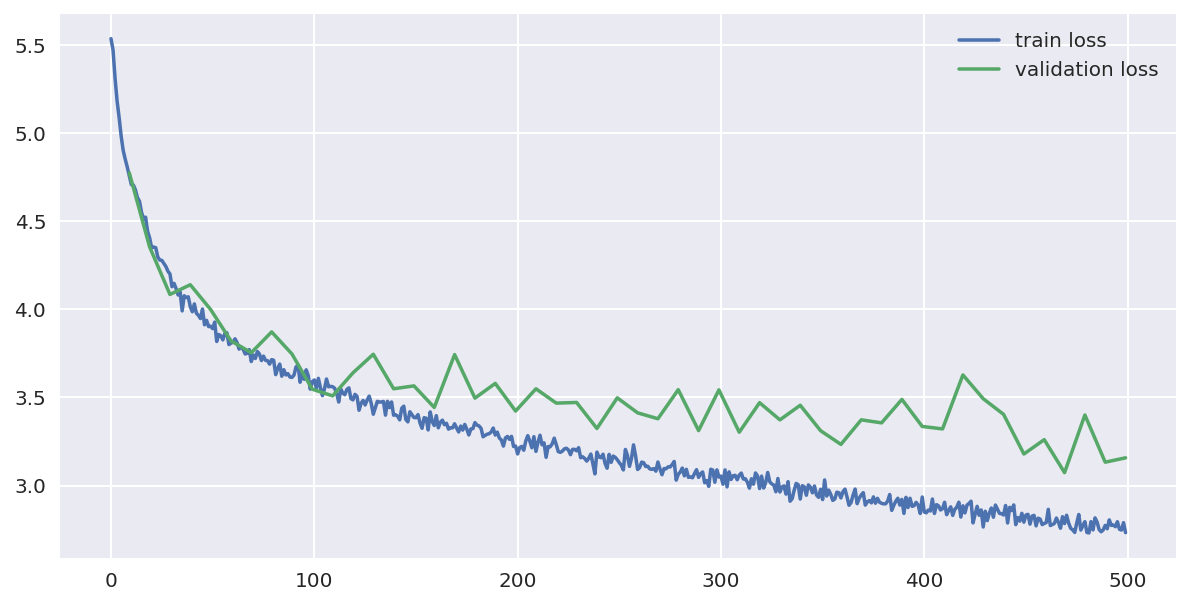

In [54]:
plot_losses(train_losses, validation_losses, validate_every // plot_every)

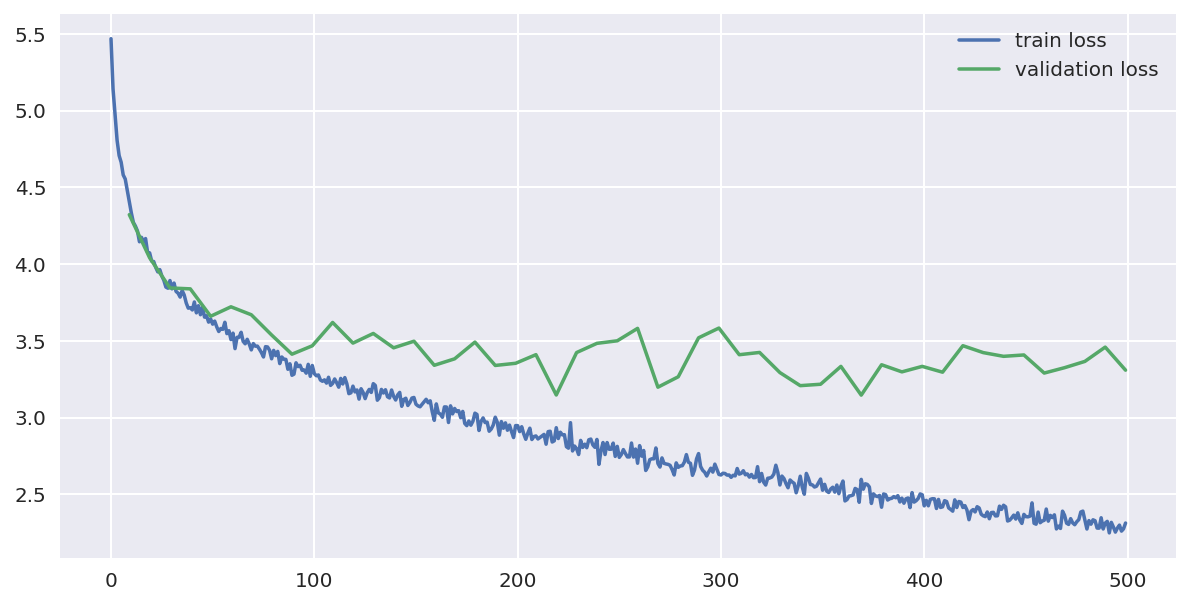

In [42]:
plot_losses(train_losses, validation_losses, validate_every // plot_every)

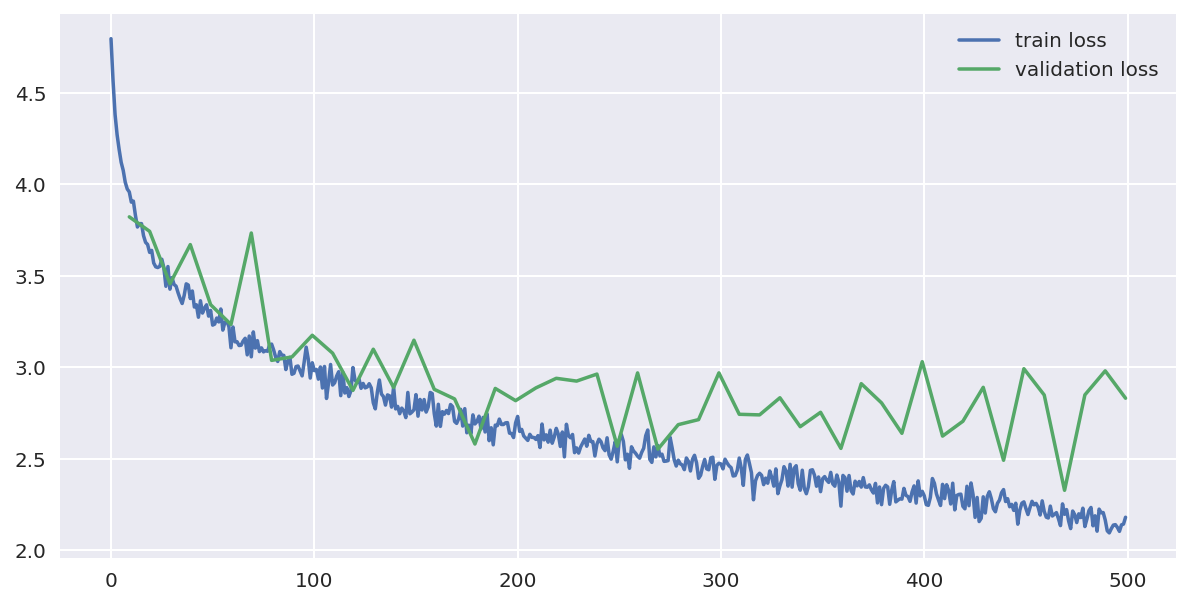

In [338]:
plot_losses(train_losses, validation_losses, validate_every // plot_every)

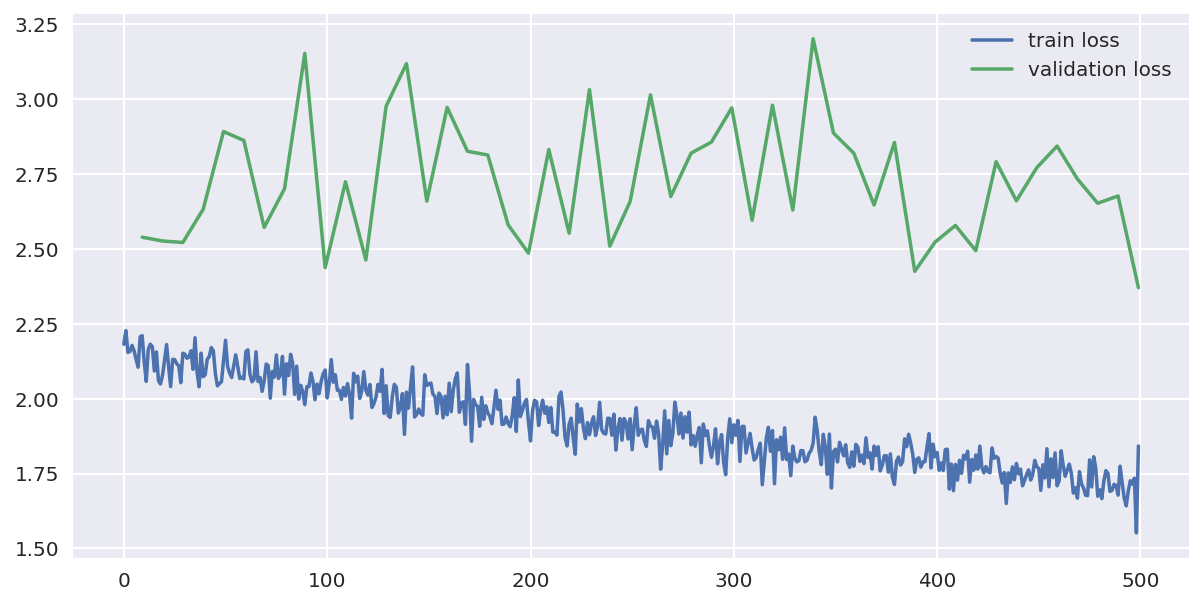

In [343]:
plot_losses(train_losses, validation_losses, validate_every // plot_every)

In [ ]:
test['challenge_id'] = label_encoders['challenge_ID'].transform(test.challenge)

In [ ]:
def get_test_sequences(df):
    sequences = []
    targets = []
    for user_id in df.user_id.unique():
        rows = df[df.user_id == user_id].sort_values('challenge_sequence')
        challenges = list(rows['challenge_id'])
        sequences.append(challenges)
    return sequences

In [ ]:
test_sequences = get_sequences(test)

In [ ]:
import torch
from torch.autograd import Variable

def get_random_batch(sequences, targets, batch_size, sequence_lengths, 
                     embedding_columns, numeric_columns):
    length = np.random.choice(sequence_lengths)
    candidates = np.array([(seq, target) for seq, target in zip(sequences, targets) if len(seq)==length])
    batch = candidates[np.random.choice(len(candidates), batch_size)]
    sequences_batch, targets_batch = zip(*batch)
    embedding_batch = [[challenge.loc[seq][col].astype('int').values for seq in sequences_batch] for col in embedding_columns]
    numeric_batch = [challenge.loc[seq][numeric_columns].astype('int').values for seq in sequences_batch]
    return sequences_batch, \
           Variable(torch.LongTensor(np.array(embedding_batch))).transpose(1, 2).cuda(), \
           Variable(torch.FloatTensor(np.array(numeric_batch))).transpose(0, 1).cuda(), \
           Variable(torch.LongTensor(targets_batch)).cuda()